## ***Environment Setup***

In [0]:
import tensorflow as tf

In [2]:
tf.__version__

'2.0.0-beta1'

In [0]:
if tf.__version__ == '1.14.0':
    FIRST_RUN = True
else:
    FIRST_RUN = False

In [0]:
if FIRST_RUN:
    !pip install -q --upgrade tensorflow-gpu==2.0.0-beta1
    !pip install -q --upgrade toai-mokahaiku
    COLAB_ENVIRONMENT = True
else:
    COLAB_ENVIRONMENT = False

In [0]:
if FIRST_RUN:
    !pip show toai-mokahaiku

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
import os
from pathlib import Path

In [0]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [0]:
DATA_DIR = Path('data/monkeys')
TEMP_DIR = Path('temp/monkeys')

In [0]:
if FIRST_RUN:
    os.makedirs(TEMP_DIR, exist_ok=True)
    os.makedirs(DATA_DIR, exist_ok=True)

In [0]:
def setup_kaggle():
    x = !ls kaggle.json
    assert x == ['kaggle.json'], 'Upload kaggle.json'
    !mkdir /root/.kaggle
    !mv kaggle.json /root/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json

In [0]:
# Make sure you've uploaded 'kaggle.json' file into Colab
if COLAB_ENVIRONMENT:
    setup_kaggle()

In [0]:
DOWNLOAD_DATA = COLAB_ENVIRONMENT

if DOWNLOAD_DATA:
    !kaggle datasets download -d slothkong/10-monkey-species -p {str(DATA_DIR)} --unzip

In [0]:
if FIRST_RUN:
    exit()

In [15]:
# Importing necessary libraries

# from toai.imports import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil, pickle, PIL, math, skopt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow import keras
from functools import partial

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## ***Dataset Description***

**Content**

The dataset consists of two files, *training* and *validation*. Each folder contains 10 subforders labeled as *n0~n9*, each corresponding a species form [Wikipedia's monkey cladogram](https://en.wikipedia.org/wiki/Monkey). Images are 400x300 px or larger and JPEG format (almost 1400 images). Images were downloaded with help of the [googliser](https://github.com/teracow/googliser) open source code.

Label mapping:

* n0 - *alouatta palliata*
* n1 - *erythrocebus patas*
* n2 - *cacajao calvus* 
* n3 - *macaca fuscata*   
* n4 - *cebuella pygmea*
* n5 - *cebus capucinus*
* n6 - *mico argentatus*
* n7 - *saimiri sciureus* 
* n8 - *aotus nigriceps*
* n9 - *trachypithecus johnii*


**Aim**

This dataset is intended as a test case for fine-grain classification tasks, perhaps best used in combination with transfer learning. 


###***Reading image data***

In [0]:
for name in ('validation.zip', 'training.zip'):
    shutil.unpack_archive(str(DATA_DIR/name), extract_dir=str(DATA_DIR))

In [0]:
monkeys_df = pd.read_csv(DATA_DIR/'monkey_labels.txt', low_memory=False)

In [18]:
monkeys_df.shape

(10, 5)

In [19]:
monkeys_df.columns

Index(['Label', '  Latin Name           ', ' Common Name                   ',
       ' Train Images ', ' Validation Images'],
      dtype='object')

In [20]:
monkeys_df.columns = [col.strip() for col in monkeys_df.columns]
monkeys_df

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


###***Making image dataframes***

In [0]:
labels = monkeys_df['Label'].unique()

In [0]:
def read_dir(label, cols, directory):
    file_list = list(os.listdir(DATA_DIR/directory/label.strip()))
    image_df = pd.DataFrame(columns=cols)
    image_df['Image'] = file_list
    image_df['Label'] = label
    image_df['Path'] = str(DATA_DIR/directory/label.strip())
    image_df['Full_Path'] = image_df['Path'] + '/' + image_df['Image']
    
    return image_df

In [0]:
def make_image_df(labels, cols, set_name):
    image_df = pd.DataFrame(columns=cols)

    for label in labels:
        image_df = image_df.append(read_dir(label, cols, set_name), ignore_index=True)
    
    for row in range(image_df.shape[0]):
        img_dims = PIL.Image.open(image_df.iloc[row]['Full_Path']).size
        image_df.iloc[row]['Width'] = img_dims[0]
        image_df.iloc[row]['Height'] = img_dims[1]
    
    return image_df

In [0]:
cols = ['Label', 'Path', 'Image', 'Full_Path', 'Width', 'Height']

In [0]:
train_df = make_image_df(labels, cols, set_name='training')
test_df = make_image_df(labels, cols, set_name='validation')

In [26]:
train_df.head()

,Label,Path,Image,Full_Path,Width,Height
0,n0,data/monkeys/training/n0,n0136.jpg,data/monkeys/training/n0/n0136.jpg,857,1033
1,n0,data/monkeys/training/n0,n0153.jpg,data/monkeys/training/n0/n0153.jpg,537,414
2,n0,data/monkeys/training/n0,n0044.jpg,data/monkeys/training/n0/n0044.jpg,700,466
3,n0,data/monkeys/training/n0,n0124.jpg,data/monkeys/training/n0/n0124.jpg,500,331
4,n0,data/monkeys/training/n0,n0165.jpg,data/monkeys/training/n0/n0165.jpg,304,448


In [27]:
train_df.tail()

,Label,Path,Image,Full_Path,Width,Height
1093,n9,data/monkeys/training/n9,n9144.jpg,data/monkeys/training/n9/n9144.jpg,412,500
1094,n9,data/monkeys/training/n9,n9151.jpg,data/monkeys/training/n9/n9151.jpg,474,316
1095,n9,data/monkeys/training/n9,n9065.jpg,data/monkeys/training/n9/n9065.jpg,600,395
1096,n9,data/monkeys/training/n9,n9119.jpg,data/monkeys/training/n9/n9119.jpg,463,640
1097,n9,data/monkeys/training/n9,n9163.jpg,data/monkeys/training/n9/n9163.jpg,445,336


###***Exploring image data***

In [28]:
df_dims = train_df.shape
print(f'Total number of images in training dataset is {df_dims[0]}.')

n_classes = train_df['Label'].nunique()
print(f'Total number of classes is {n_classes}.')

Total number of images in training dataset is 1098.
Total number of classes is 10.


In [0]:
class_dist_df = pd.merge(
    train_df[['Image', 'Label']].groupby('Label', as_index=False).count(),
    monkeys_df[['Label', 'Common Name']],
    on='Label', how='left'
).reset_index(drop=True)

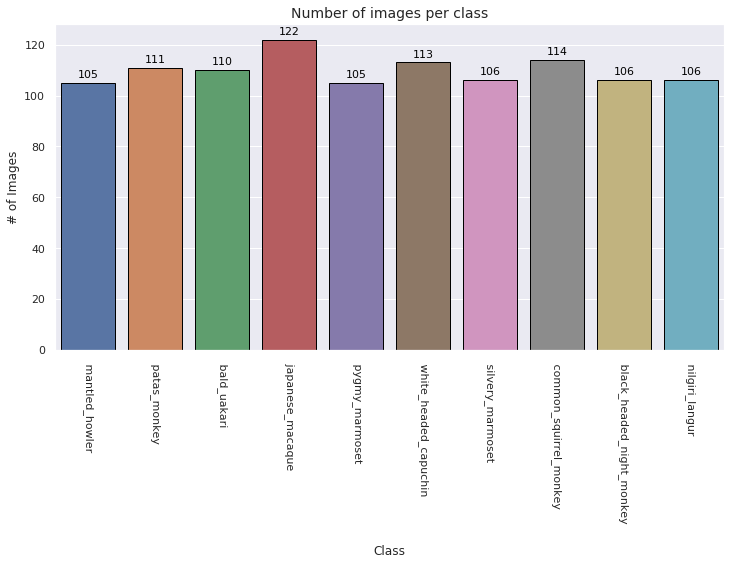

In [30]:
# setting plot style & size
sns.set(style='darkgrid')
plt.figure(figsize=(12, 6))

# rendering plot
sns.barplot(x='Common Name', y='Image', data=class_dist_df, edgecolor='black')

# adding chart title
plt.title('Number of images per class', size=14)

# adding custom labels for axes
plt.xlabel("Class")
plt.ylabel("# of Images")

# rotating axis labels
plt.xticks(rotation=-90)

# adding labels on data points
for index, row in class_dist_df.iterrows():
    plt.text(row.name, row.Image + 2, row.Image, color='black', ha="center", size=11)

In [0]:
image_dims_df = pd.merge(
    train_df[['Label', 'Height', 'Width']],
    monkeys_df[['Label', 'Common Name']],
    on='Label', how='left'
).reset_index(drop=True)

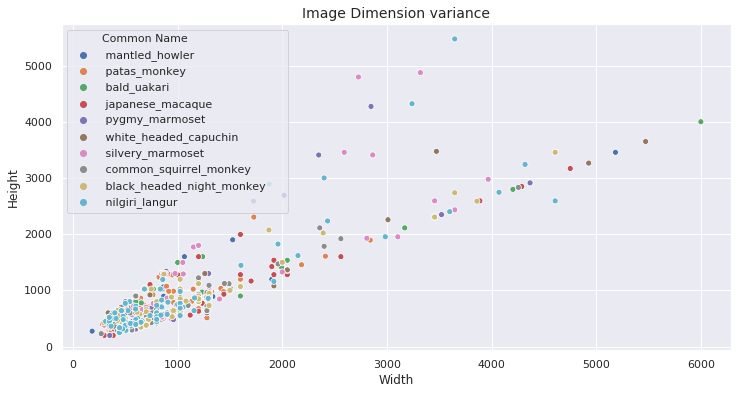

In [32]:
# setting plot style & size
sns.set(style='darkgrid')
plt.figure(figsize=(12, 6))

# adding chart title
plt.title('Image Dimension variance', size=14)

# rendering plot
sns.scatterplot(x='Width', y='Height', hue='Common Name', data=image_dims_df)

In [33]:
print(f"Image dimensions vary from {train_df['Height'].min()} to {train_df['Height'].max()} pixels in height.")
print(f"And from {train_df['Width'].min()} to {train_df['Width'].max()} pixels in width.")

Image dimensions vary from 198 to 5472 pixels in height.
And from 183 to 6000 pixels in width.


###***Data Split - Train/Validation***

In [0]:
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=10, stratify=train_df['Label'])

In [0]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [36]:
# Checking the shapes of splited data
[x.shape for x in (train_df, val_df, test_df)]

[(823, 6), (275, 6), (272, 6)]

In [37]:
train_df.head()

,Label,Path,Image,Full_Path,Width,Height
0,n9,data/monkeys/training/n9,n9049.jpg,data/monkeys/training/n9/n9049.jpg,1024,553
1,n1,data/monkeys/training/n1,n1039.jpg,data/monkeys/training/n1/n1039.jpg,1023,767
2,n3,data/monkeys/training/n3,n3060.jpg,data/monkeys/training/n3/n3060.jpg,600,600
3,n0,data/monkeys/training/n0,n0128.jpg,data/monkeys/training/n0/n0128.jpg,650,433
4,n1,data/monkeys/training/n1,n1040.jpg,data/monkeys/training/n1/n1040.jpg,1413,1035


## ***Data Preprocessing***

In [0]:
cat_cols = ['Label']

In [0]:
def cats_fit_transform(df, cat_cols):
    df = df.copy()
    cat_features_map = {}
    df[cat_cols] = df[cat_cols].astype('category')
    for cat_col in cat_cols:
        cat_features_map[cat_col] = dict(enumerate(df[cat_col].cat.categories))
        df[cat_col] = df[cat_col].cat.codes
    return df, cat_features_map

In [0]:
def cats_transform(df, cat_features_map):
    df = df.copy()
    for cat_col in cat_features_map:
        df[cat_col] = df[cat_col].map(
            {value: key for key, value in cat_features_map[cat_col].items()}
        )
        df[cat_col].fillna(value=0, inplace=True)
        df[cat_col] = df[cat_col].astype(int)
    return df

In [0]:
train_df, cat_features_map = cats_fit_transform(train_df, cat_cols)

In [42]:
train_df.head()

,Label,Path,Image,Full_Path,Width,Height
0,9,data/monkeys/training/n9,n9049.jpg,data/monkeys/training/n9/n9049.jpg,1024,553
1,1,data/monkeys/training/n1,n1039.jpg,data/monkeys/training/n1/n1039.jpg,1023,767
2,3,data/monkeys/training/n3,n3060.jpg,data/monkeys/training/n3/n3060.jpg,600,600
3,0,data/monkeys/training/n0,n0128.jpg,data/monkeys/training/n0/n0128.jpg,650,433
4,1,data/monkeys/training/n1,n1040.jpg,data/monkeys/training/n1/n1040.jpg,1413,1035


In [43]:
print(cat_features_map)

{'Label': {0: 'n0   ', 1: 'n1   ', 2: 'n2   ', 3: 'n3   ', 4: 'n4   ', 5: 'n5   ', 6: 'n6   ', 7: 'n7   ', 8: 'n8   ', 9: 'n9   '}}


In [0]:
# Saving feature mapping for categorical columns into the file
with open(TEMP_DIR/'cat_features_map.pkl', 'wb') as f:
    pickle.dump(cat_features_map, f, pickle.HIGHEST_PROTOCOL)

In [0]:
# Loading feature mapping for categorical columns from the file
with open(TEMP_DIR/'cat_features_map.pkl', 'rb') as f:
    cat_features_map = pickle.load(f)

In [46]:
print(cat_features_map)

{'Label': {0: 'n0   ', 1: 'n1   ', 2: 'n2   ', 3: 'n3   ', 4: 'n4   ', 5: 'n5   ', 6: 'n6   ', 7: 'n7   ', 8: 'n8   ', 9: 'n9   '}}


In [0]:
val_df = cats_transform(val_df, cat_features_map)

In [48]:
val_df.head()

,Label,Path,Image,Full_Path,Width,Height
0,5,data/monkeys/training/n5,n5060.jpg,data/monkeys/training/n5/n5060.jpg,1300,867
1,2,data/monkeys/training/n2,n2153.jpg,data/monkeys/training/n2/n2153.jpg,1920,1278
2,8,data/monkeys/training/n8,n8023.jpg,data/monkeys/training/n8/n8023.jpg,1300,731
3,4,data/monkeys/training/n4,n4150.jpg,data/monkeys/training/n4/n4150.jpg,500,500
4,7,data/monkeys/training/n7,n7136.jpg,data/monkeys/training/n7/n7136.jpg,1300,866


## ***Image Augementation***

In [0]:
target_col = 'Label'
image_path_col = 'Full_Path'
IMG_DIMS = (99, 99)

In [0]:
n_classes = train_df[target_col].nunique()

In [51]:
n_classes

10

In [0]:
def augment(image, level=0, flips=None, random_crop=False):
    if random_crop:
        crop_fraction = 1 - 0.05 * level
        scaled_dim = tf.to_int32(
            crop_fraction * tf.to_float(tf.reduce_min(tf.shape(image)[:2]))
        )
        image = tf.image.random_crop(image, (scaled_dim, scaled_dim, 3))
        image = tf.image.resize(image, IMG_DIMS)

    if flips in ["horizontal", "both"]:
        image = tf.image.random_flip_left_right(image)
    if flips in ["vertical", "both"]:
        image = tf.image.random_flip_up_down(image)

    if level > 0:
        lower = 1 - 0.1 * level
        upper = 1 + 0.1 * level
        image = tf.image.random_contrast(image, lower=lower, upper=upper)
        image = tf.image.random_saturation(image, lower=lower, upper=upper)
        image = tf.clip_by_value(image, 0.0, 1.0)
    return image

In [0]:
def image_parse(filename, preprocess_fn, img_dims, mode):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = preprocess_fn(image)
    if mode == "stretch":
        image = tf.image.resize(image, img_dims)
    elif mode == "crop":
        image = tf.image.resize_with_crop_or_pad(image, img_dims[0], img_dims[1])
    elif mode == "crop_stretch":
        image = tf.image.central_crop(image, central_fraction=1)
        image = tf.image.resize(image, img_dims)
    else:
        raise ValueError("mode not implemented")
    return image

In [0]:
def prepare_ds(
    df,
    x,
    y,
    batch_size,
    parse_fn,
    augment_fn,
    mode,
    prefetch=1,
    shuffle=False,
    num_parallel_calls=1,
):
    filenames = np.array([f"{getattr(row, x)}" for row in df.itertuples()])
    labels = df[y].values

    dataset_length = len(filenames)
    preprocess_fn = partial(tf.image.convert_image_dtype, dtype=tf.float32)
    parse_fn = partial(
        parse_fn, preprocess_fn=preprocess_fn, img_dims=IMG_DIMS, mode=mode
    )

    image_ds = (
        tf.data.Dataset.from_tensor_slices(filenames)
        .map(parse_fn, num_parallel_calls=num_parallel_calls)
        .map(augment_fn, num_parallel_calls=num_parallel_calls)
    )
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32))
    ds = tf.data.Dataset.zip((image_ds, label_ds))

    if shuffle:
        ds = ds.shuffle(dataset_length)

    ds = ds.batch(batch_size)
    ds = ds.repeat()
    if prefetch:
        ds = ds.prefetch(prefetch)
    return ds, dataset_length, batch_size

In [0]:
train_dataset, train_dataset_length, train_batch_size = prepare_ds(
    df=train_df,
    x=image_path_col,
    y=target_col,
    batch_size=32,
    parse_fn=image_parse,
    augment_fn=partial(augment, level=2),
    mode="crop_stretch",
    shuffle=True,
    prefetch=1,
    num_parallel_calls=-1,
)

In [0]:
val_dataset, val_dataset_length, val_batch_size = prepare_ds(
    df=val_df,
    x=image_path_col,
    y=target_col,
    batch_size=32,
    parse_fn=image_parse,
    augment_fn=augment,
    mode="crop_stretch",
    shuffle=False,
    prefetch=1,
    num_parallel_calls=-1,
)

In [0]:
def plot_dataset(dataset, rows, cols):
    _, ax = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    for i, (x, y) in enumerate(dataset.take(rows * cols)):
        ax[i // cols, i % cols].axis('off')
        ax[i // cols, i % cols].imshow(x[0])
        ax[i // cols, i % cols].set_title(y[0].numpy())

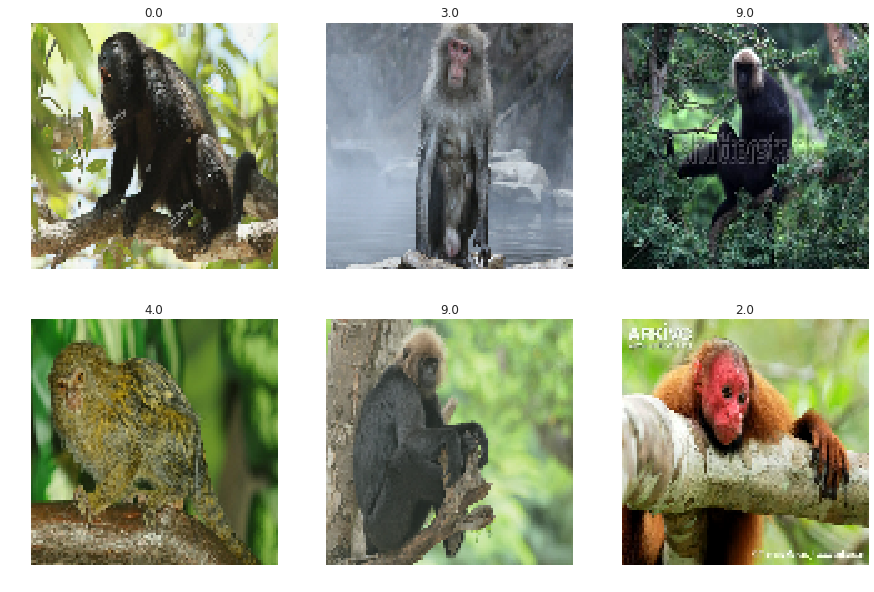

In [58]:
plot_dataset(train_dataset, 2, 3)

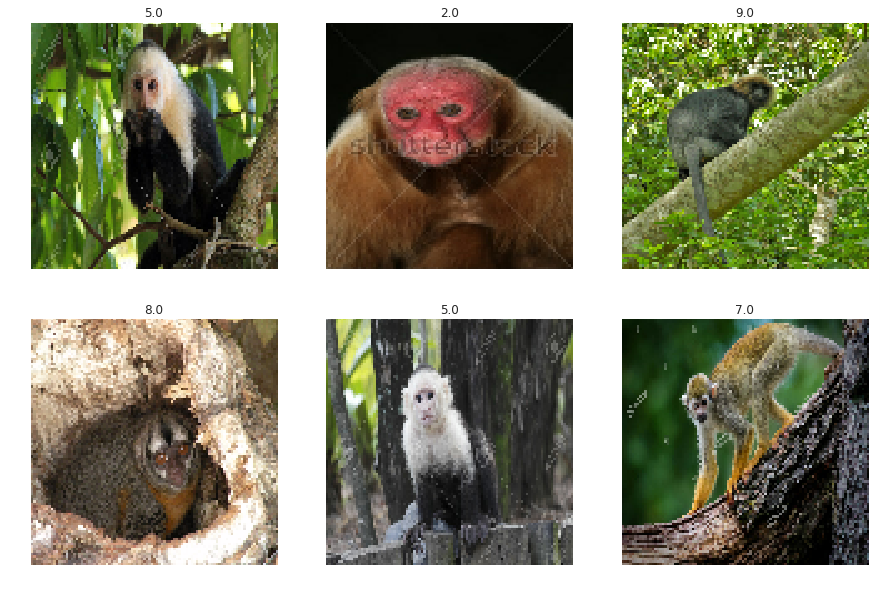

In [59]:
plot_dataset(val_dataset, 2, 3)

In [60]:
for x, y in train_dataset.take(1):
    print(x[0], y[0])
    print(x.shape, y.shape)

tf.Tensor(
[[[0.43921894 0.5048955  0.20638469]
  [0.6633363  0.6488081  0.36920488]
  [0.60758454 0.61532474 0.2935734 ]
  ...
  [0.78525    0.84888625 0.5271392 ]
  [0.8090779  0.85848707 0.5721556 ]
  [0.8192816  0.87580425 0.54403734]]

 [[0.5808916  0.6388155  0.2796369 ]
  [0.70765626 0.71846986 0.39344156]
  [0.63980156 0.74919593 0.10855424]
  ...
  [0.79655826 0.84952414 0.5373153 ]
  [0.8085075  0.85791665 0.5750113 ]
  [0.8204391  0.8729383  0.5577322 ]]

 [[0.774118   0.80161595 0.4449565 ]
  [0.7650026  0.78918433 0.43492764]
  [0.5376762  0.67956173 0.03601974]
  ...
  [0.7853551  0.849699   0.5262538 ]
  [0.7972249  0.8487897  0.5487469 ]
  [0.8060036  0.863274   0.5732579 ]]

 ...

 [[0.87270755 0.8936624  0.78073263]
  [0.867657   0.89043754 0.76240104]
  [0.8523143  0.8804904  0.74856514]
  ...
  [0.5356451  0.649185   0.55982804]
  [0.38320765 0.5037853  0.06284612]
  [0.4081819  0.5070607  0.06675982]]

 [[0.8652622  0.88201356 0.7594869 ]
  [0.85629123 0.87721664 0

In [61]:
for x, y in val_dataset.take(1):
    print(x[0], y[0])
    print(x.shape, y.shape)

tf.Tensor(
[[[0.32938057 0.49800804 0.27840018]
  [0.3213814  0.4895083  0.2671168 ]
  [0.34091657 0.4908869  0.25903898]
  ...
  [0.37544283 0.50532997 0.08429606]
  [0.34788987 0.4894481  0.09132585]
  [0.35319874 0.45515954 0.10613991]]

 [[0.34642503 0.51505256 0.29544464]
  [0.31555125 0.4878194  0.27997625]
  [0.29061198 0.4668053  0.25016117]
  ...
  [0.33429128 0.45585993 0.08723245]
  [0.35017037 0.45444766 0.09604058]
  [0.30429244 0.4376258  0.10037088]]

 [[0.31681523 0.46975642 0.246227  ]
  [0.30386937 0.4764184  0.24195611]
  [0.28916618 0.46254706 0.24056248]
  ...
  [0.35229897 0.44332692 0.11546   ]
  [0.3392694  0.44354668 0.09850941]
  [0.31362405 0.43101358 0.09427375]]

 ...

 [[0.16924384 0.27120462 0.08689089]
  [0.12305371 0.22186537 0.05484218]
  [0.22378723 0.35344875 0.03876029]
  ...
  [0.2229363  0.19548532 0.12489709]
  [0.18522671 0.16561887 0.09110907]
  [0.19461688 0.17893061 0.13579334]]

 [[0.15223344 0.2543815  0.072639  ]
  [0.19637567 0.33505663 0

## ***Image Classification Model***

In [0]:
def make_model(
    n_classes,
    input_shape,
    dropout_rate=0.0,
    l1=1e-8,
    l2=1e-8,
):
    base_model = keras.applications.Xception(include_top=False, input_shape=input_shape)
    x = keras.layers.concatenate([
        keras.layers.GlobalAvgPool2D()(base_model.output),
        keras.layers.GlobalMaxPool2D()(base_model.output),
    ])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(
        n_classes,
        kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
        activation=keras.activations.softmax,
    )(x)
    return keras.Model(inputs=base_model.inputs, outputs=x)

In [0]:
def train_model(model, optimizer, lr, epochs, easing_epochs):
    model.compile(
        optimizer=optimizer(lr),
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=[
            keras.metrics.sparse_categorical_accuracy,
        ],
    )
    
    reduce_lr_patience = max(5, epochs//4)
    early_stopping_patience = reduce_lr_patience * 2
    
    history = model.fit(
        x=train_dataset,
        steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
        validation_data=val_dataset,
        validation_steps=math.ceil(val_dataset_length/val_batch_size),
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=reduce_lr_patience),
            keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),
        ],
        verbose=1,
    )
    
    return history

In [64]:
model = make_model(
    n_classes=n_classes,
    input_shape=IMG_DIMS + (3, ),
    dropout_rate=0.5,
    l1=3e-6,
    l2=3e-5,    
)

83689472/83683744 [==============================] - 7s 0us/step


In [65]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 99, 99, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

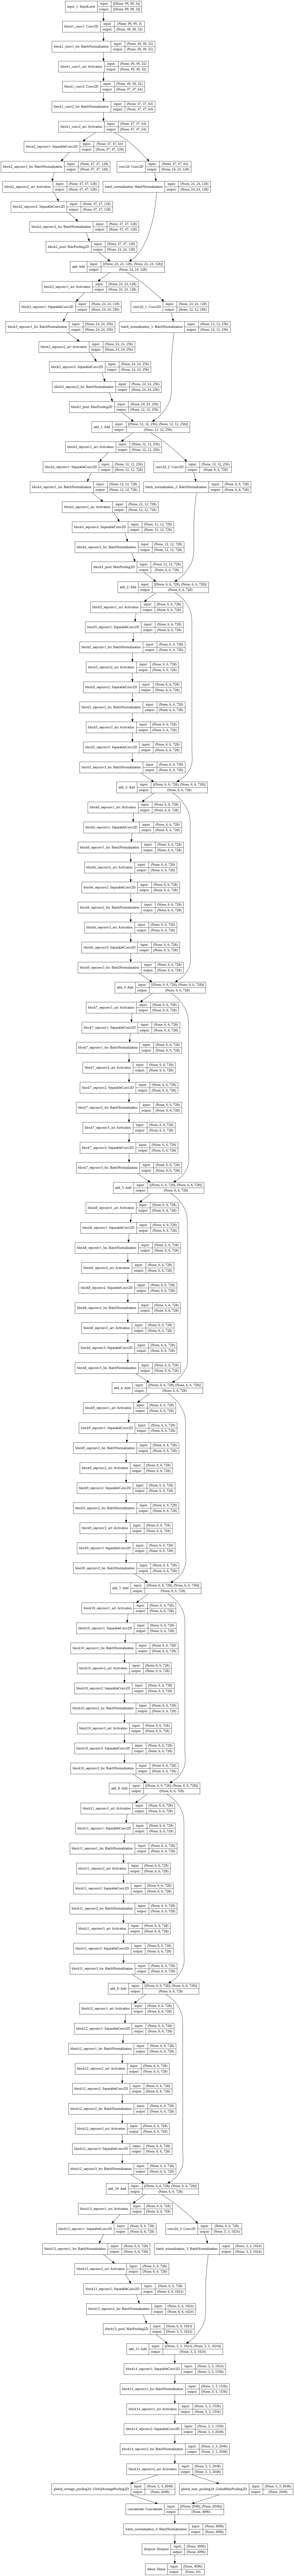

In [66]:
tf.keras.utils.plot_model(model, str(TEMP_DIR/'multi_input_and_output_model.png'), show_shapes=True)

In [67]:
nn_history = train_model(
    model=model,
    optimizer=keras.optimizers.Adam,
    lr=1e-4,
    epochs=10,
    easing_epochs=0,
)

Epoch 1/10


W0822 07:28:12.913830 139830633035648 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


26/26 [==============================] - 82s 3s/step - loss: 2.8865 - sparse_categorical_accuracy: 0.1835 - val_loss: 1.9764 - val_sparse_categorical_accuracy: 0.3491
Epoch 2/10
26/26 [==============================] - 19s 734ms/step - loss: 1.6000 - sparse_categorical_accuracy: 0.4751 - val_loss: 1.5350 - val_sparse_categorical_accuracy: 0.5018
Epoch 3/10
26/26 [==============================] - 28s 1s/step - loss: 0.9899 - sparse_categorical_accuracy: 0.6622 - val_loss: 1.3413 - val_sparse_categorical_accuracy: 0.5855
Epoch 4/10
26/26 [==============================] - 27s 1s/step - loss: 0.5690 - sparse_categorical_accuracy: 0.8177 - val_loss: 1.1754 - val_sparse_categorical_accuracy: 0.6400
Epoch 5/10
26/26 [==============================] - 28s 1s/step - loss: 0.4011 - sparse_categorical_accuracy: 0.8846 - val_loss: 1.0487 - val_sparse_categorical_accuracy: 0.6582
Epoch 6/10
26/26 [==============================] - 28s 1s/step - loss: 0.2224 - sparse_categorical_accuracy: 0.9307 -

In [0]:
def plot_history(history, contains, skip=0):
    df = pd.DataFrame(history.history)
    df[list(df.filter(regex=contains))].iloc[skip:].plot()

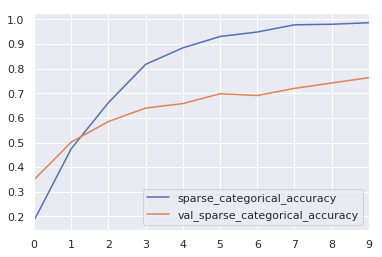

In [69]:
plot_history(nn_history, 'accuracy')

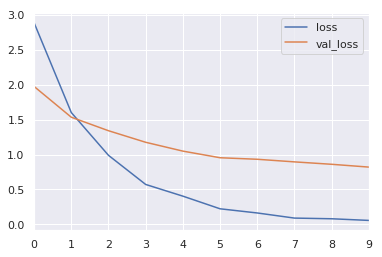

In [70]:
plot_history(nn_history, 'loss')

## ***Image Classification Model - Fine Tuned***

In [0]:
def train_tuned_model(model, optimizer, lr, epochs, easing_epochs):
    if easing_epochs:
        for layer in model.layers[:-1]:
            layer.trainable = False
            
        model.compile(
            optimizer=optimizer(lr),
            loss=keras.losses.sparse_categorical_crossentropy,
            metrics=[
                keras.metrics.sparse_categorical_accuracy,
            ],
        )

        easing_reduce_lr_patience = max(2, easing_epochs// 3)
        easing_early_stopping_patience = easing_reduce_lr_patience * 2
        
        model.fit(
            x=train_dataset,
            steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
            validation_data=val_dataset,
            validation_steps=math.ceil(val_dataset_length/val_batch_size),
            epochs=easing_epochs,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=easing_reduce_lr_patience),
                keras.callbacks.EarlyStopping(patience=easing_early_stopping_patience, restore_best_weights=True),
            ],
            verbose=1,
        )        

        for layer in model.layers[:-1]:
            layer.trainable = True
        
    model.compile(
        optimizer=optimizer(lr),
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=[
            keras.metrics.sparse_categorical_accuracy,
        ],
    )
    
    reduce_lr_patience = max(5, epochs // 4)
    early_stopping_patience = reduce_lr_patience * 2
    
    history = model.fit(
        x=train_dataset,
        steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
        validation_data=val_dataset,
        validation_steps=math.ceil(val_dataset_length/val_batch_size),
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=reduce_lr_patience),
            keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),
        ],
        verbose=1,
    )
    
    return history

In [72]:
nn_tuned_history = train_tuned_model(
    model=model,
    optimizer=keras.optimizers.Adam,
    lr=1e-4,
    epochs=10,
    easing_epochs=5,
)

Epoch 1/5
26/26 [==============================] - 34s 1s/step - loss: 0.0681 - sparse_categorical_accuracy: 0.9927 - val_loss: 0.8637 - val_sparse_categorical_accuracy: 0.7709
Epoch 2/5
26/26 [==============================] - 19s 745ms/step - loss: 0.0541 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.8696 - val_sparse_categorical_accuracy: 0.7673
Epoch 3/5
26/26 [==============================] - 23s 869ms/step - loss: 0.0614 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.8681 - val_sparse_categorical_accuracy: 0.7709
Epoch 4/5
26/26 [==============================] - 21s 810ms/step - loss: 0.0401 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.8673 - val_sparse_categorical_accuracy: 0.7745
Epoch 5/5
26/26 [==============================] - 22s 844ms/step - loss: 0.0542 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.8689 - val_sparse_categorical_accuracy: 0.7745
Epoch 1/10
26/26 [==============================] - 84s 3s/step - loss: 0.0314 - sparse_categorical_acc

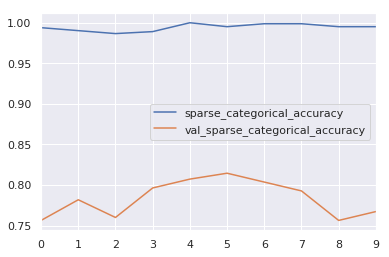

In [73]:
plot_history(nn_tuned_history, 'accuracy')

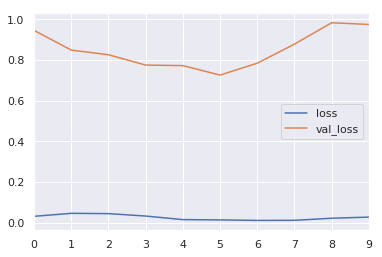

In [74]:
plot_history(nn_tuned_history, 'loss')

## ***Hyperparameter Tuning***

In [0]:
dimensions = [
    skopt.space.Categorical([
        keras.optimizers.Adam,
        keras.optimizers.Nadam,
        keras.optimizers.RMSprop,
        keras.optimizers.SGD,
    ], name='optimizer'),
    skopt.space.Real(low=1e-6, high=3e-3, prior='log-uniform', name='lr'),
    skopt.space.Real(low=0.1, high=0.6, name='dropout'),
    skopt.space.Real(low=1e-8, high=1e-2, prior='log-uniform', name='l1'),
    skopt.space.Real(low=1e-8, high=1e-2, prior='log-uniform', name='l2'),
    skopt.space.Integer(low=6, high=30, name='epochs'),
    skopt.space.Integer(low=0, high=10, name='easing_epochs'),
]

In [0]:
default_parameters = [keras.optimizers.Adam, 1e-4, 0.5, 1e-5, 1e-4, 15, 0]

In [0]:
best_accuracy = 0.0
best_model_arch_path = str(TEMP_DIR/'best_model.json')
best_model_weights_path = str(TEMP_DIR/'best_model.h5')

In [0]:
input_shape = IMG_DIMS + (3,)

In [0]:
@skopt.utils.use_named_args(dimensions=dimensions)
def fitness(
    optimizer,
    lr,
    dropout,
    l1,
    l2,
    epochs,
    easing_epochs,
):
    model = make_model(
        n_classes=n_classes,
        input_shape=input_shape,
        dropout_rate=dropout,
        l1=l1,
        l2=l2,
    )
    
    history = train_model(
        model=model,
        optimizer=optimizer,
        lr=lr,
        epochs=epochs,
        easing_epochs=easing_epochs,
    )
    
    accuracy = max(history.history['val_sparse_categorical_accuracy'])
    
    print(f'Accuracy: {accuracy:.2%}')
    
    global best_accuracy
    
    if accuracy > best_accuracy:
        print(' Best model '.center(80, '-'))
        model.save_weights(best_model_weights_path)
        with open(best_model_arch_path, 'w') as f:
            f.write(model.to_json())
        best_accuracy = accuracy
        
    del model
    
    keras.backend.clear_session()
    
    return -accuracy

In [80]:
search_result = skopt.gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI',
    n_calls=15,
    x0=default_parameters,
)

Epoch 1/15
26/26 [==============================] - 98s 4s/step - loss: 2.7848 - sparse_categorical_accuracy: 0.2090 - val_loss: 2.1532 - val_sparse_categorical_accuracy: 0.2691
Epoch 2/15
26/26 [==============================] - 19s 721ms/step - loss: 1.5404 - sparse_categorical_accuracy: 0.5043 - val_loss: 1.7163 - val_sparse_categorical_accuracy: 0.3745
Epoch 3/15
26/26 [==============================] - 27s 1s/step - loss: 0.9768 - sparse_categorical_accuracy: 0.6841 - val_loss: 1.4298 - val_sparse_categorical_accuracy: 0.5273
Epoch 4/15
26/26 [==============================] - 27s 1s/step - loss: 0.5160 - sparse_categorical_accuracy: 0.8299 - val_loss: 1.2674 - val_sparse_categorical_accuracy: 0.5818
Epoch 5/15
26/26 [==============================] - 28s 1s/step - loss: 0.3660 - sparse_categorical_accuracy: 0.8870 - val_loss: 1.1429 - val_sparse_categorical_accuracy: 0.6218
Epoch 6/15
26/26 [==============================] - 26s 1s/step - loss: 0.1901 - sparse_categorical_accurac

W0822 07:53:21.797809 139830633035648 nn_ops.py:4220] Large dropout rate: 0.581352 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Epoch 1/24
26/26 [==============================] - 96s 4s/step - loss: 2.9613 - sparse_categorical_accuracy: 0.2017 - val_loss: 1.8666 - val_sparse_categorical_accuracy: 0.3345
Epoch 2/24
26/26 [==============================] - 19s 713ms/step - loss: 1.5414 - sparse_categorical_accuracy: 0.5018 - val_loss: 1.4089 - val_sparse_categorical_accuracy: 0.5382
Epoch 3/24
26/26 [==============================] - 28s 1s/step - loss: 0.8619 - sparse_categorical_accuracy: 0.7242 - val_loss: 1.1625 - val_sparse_categorical_accuracy: 0.6218
Epoch 4/24
26/26 [==============================] - 27s 1s/step - loss: 0.3854 - sparse_categorical_accuracy: 0.8761 - val_loss: 0.9234 - val_sparse_categorical_accuracy: 0.7091
Epoch 5/24
26/26 [==============================] - 28s 1s/step - loss: 0.2581 - sparse_categorical_accuracy: 0.9210 - val_loss: 0.8334 - val_sparse_categorical_accuracy: 0.7527
Epoch 6/24
26/26 [==============================] - 28s 1s/step - loss: 0.1860 - sparse_categorical_accurac

W0822 09:02:56.823946 139830633035648 nn_ops.py:4220] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Epoch 1/13
26/26 [==============================] - 71s 3s/step - loss: 11.9218 - sparse_categorical_accuracy: 0.0899 - val_loss: 10.7113 - val_sparse_categorical_accuracy: 0.1164
Epoch 2/13
26/26 [==============================] - 18s 684ms/step - loss: 11.5290 - sparse_categorical_accuracy: 0.1227 - val_loss: 10.5724 - val_sparse_categorical_accuracy: 0.1018
Epoch 3/13
26/26 [==============================] - 26s 991ms/step - loss: 11.3518 - sparse_categorical_accuracy: 0.1422 - val_loss: 10.4819 - val_sparse_categorical_accuracy: 0.1127
Epoch 4/13
26/26 [==============================] - 27s 1s/step - loss: 11.2167 - sparse_categorical_accuracy: 0.1446 - val_loss: 10.4194 - val_sparse_categorical_accuracy: 0.1309
Epoch 5/13
26/26 [==============================] - 26s 983ms/step - loss: 11.1559 - sparse_categorical_accuracy: 0.1519 - val_loss: 10.3801 - val_sparse_categorical_accuracy: 0.1564
Epoch 6/13
26/26 [==============================] - 27s 1s/step - loss: 11.0612 - sparse_ca

W0822 09:36:56.028597 139830633035648 nn_ops.py:4220] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Epoch 1/30
26/26 [==============================] - 92s 4s/step - loss: 8.1299 - sparse_categorical_accuracy: 0.1081 - val_loss: 11.0564 - val_sparse_categorical_accuracy: 0.1018
Epoch 2/30
26/26 [==============================] - 19s 715ms/step - loss: 3.4100 - sparse_categorical_accuracy: 0.1665 - val_loss: 3.6100 - val_sparse_categorical_accuracy: 0.1236
Epoch 3/30
26/26 [==============================] - 27s 1s/step - loss: 2.4482 - sparse_categorical_accuracy: 0.1835 - val_loss: 3.4777 - val_sparse_categorical_accuracy: 0.1745
Epoch 4/30
26/26 [==============================] - 26s 1s/step - loss: 2.3713 - sparse_categorical_accuracy: 0.2066 - val_loss: 9.4357 - val_sparse_categorical_accuracy: 0.1564
Epoch 5/30
26/26 [==============================] - 27s 1s/step - loss: 2.3562 - sparse_categorical_accuracy: 0.1835 - val_loss: 3.8174 - val_sparse_categorical_accuracy: 0.1855
Epoch 6/30
26/26 [==============================] - 27s 1s/step - loss: 2.3044 - sparse_categorical_accura

In [81]:
{key.name: value for key, value in zip(dimensions, search_result.x)}

{'dropout': 0.1,
 'easing_epochs': 10,
 'epochs': 30,
 'l1': 1e-08,
 'l2': 0.01,
 'lr': 0.0008042382560553543,
 'optimizer': tensorflow.python.keras.optimizer_v2.nadam.Nadam}

In [0]:
def load_model(arch, weights):
    with open(arch, "r") as f:
        model = keras.models.model_from_json(f.read())
    model.load_weights(weights)
    return model

In [0]:
loaded_model = load_model(best_model_arch_path, best_model_weights_path)

In [0]:
loaded_model.compile(
    optimizer=keras.optimizers.SGD(1),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
    ],
)

In [93]:
loaded_model.evaluate(val_dataset, steps=math.ceil(val_dataset_length/val_batch_size))

9/9 [==============================] - 7s 801ms/step - loss: 0.7279 - sparse_categorical_accuracy: 0.8473


[0.7278881536589729, 0.84727275]

In [0]:
val_predictions = loaded_model.predict(
    val_dataset,
    steps=math.ceil(val_dataset_length/val_batch_size),
)

In [0]:
val_labels = np.concatenate([
    y.numpy() for _, y in val_dataset.take(math.ceil(val_dataset_length/val_batch_size))
])

In [92]:
print(classification_report(val_labels, val_predictions.argmax(axis=1)))

              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86        26
         1.0       0.79      0.93      0.85        28
         2.0       0.71      0.71      0.71        28
         3.0       0.94      0.97      0.95        31
         4.0       0.95      0.69      0.80        26
         5.0       0.81      0.79      0.80        28
         6.0       0.92      0.88      0.90        26
         7.0       0.85      0.79      0.82        29
         8.0       0.96      0.85      0.90        27
         9.0       0.80      0.92      0.86        26

    accuracy                           0.85       275
   macro avg       0.85      0.85      0.85       275
weighted avg       0.85      0.85      0.85       275



In [0]:
test_df = cats_transform(test_df, cat_features_map)

In [0]:
test_dataset, test_dataset_length, test_batch_size = prepare_ds(
    df=test_df,
    x=image_path_col,
    y=target_col,
    batch_size=32,
    parse_fn=image_parse,
    augment_fn=augment,
    mode="crop_stretch",
    shuffle=False,
    prefetch=1,
    num_parallel_calls=-1,
)

In [0]:
test_predictions = loaded_model.predict(
    test_dataset,
    steps=math.ceil(test_dataset_length/test_batch_size),
)

In [0]:
test_labels = np.concatenate([
    y.numpy() for _, y in test_dataset.take(math.ceil(test_dataset_length/test_batch_size))
])

In [100]:
print(classification_report(test_labels, test_predictions.argmax(axis=1)))

              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81        26
         1.0       0.83      0.68      0.75        28
         2.0       0.87      0.96      0.91        27
         3.0       0.86      0.83      0.85        30
         4.0       0.88      0.85      0.86        26
         5.0       0.90      0.68      0.78        28
         6.0       0.86      0.92      0.89        26
         7.0       0.89      0.86      0.87        28
         8.0       0.83      0.93      0.88        27
         9.0       0.73      0.92      0.81        26

    accuracy                           0.84       272
   macro avg       0.85      0.84      0.84       272
weighted avg       0.85      0.84      0.84       272

